In [3]:
from scipy.stats import ttest_1samp
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
import itertools
import numpy as np
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, pearsonr, spearmanr, \
    kendalltau, f_oneway, kruskal

In [10]:
df = pd.read_excel(r'C:\Users\User\Desktop\AB_test\cookie_cats2.xlsx')
df.head

<bound method NDFrame.head of         userid  version  sum_gamerounds  retention_1  retention_7
0          116  gate_30               3            0            0
1          337  gate_30              38            1            0
2          377  gate_40             165            1            0
3          483  gate_40               1            0            0
4          488  gate_40             179            1            1
...        ...      ...             ...          ...          ...
90184  9999441  gate_40              97            1            0
90185  9999479  gate_40              30            0            0
90186  9999710  gate_30              28            1            0
90187  9999768  gate_40              51            1            0
90188  9999861  gate_40              16            0            0

[90189 rows x 5 columns]>

<h1> Анализ исследования:</h1>
Набор данных и переменные Данные, которыми мы располагаем, получены от 90 189 игроков, которые установили игру во время выполнения AB-теста. Переменными являются:

userid - уникальный номер, который идентифицирует каждого игрока.

version - был ли игрок помещен в контрольную группу (gate_30 - ворота на 30-м уровне) или в группу с перемещенными воротами (gate_40 - ворота на 40-м уровне).


sum_gamerounds - количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки.


retention_1 - вернулся ли плеер и играл ли он через 1 день после установки?


retention_7 - вернулся ли плеер и играл ли он через 7 дней после установки? Когда игрок устанавливал игру.

Когда игрок устанавливал игру, ему было случайно назначено одно из двух групп - gate_30 или gate_40. Для проверки корректности, давайте посмотрим, приблизительно одинаковое ли количество игроков в каждой группе AB.

In [42]:
df.groupby('version')['version'].count()

version
gate_30    44700
gate_40    45489
Name: version, dtype: int64

В каждой группе примерно одинаковое количество игроков.

Основной упор в этом анализе будет сделан на то, как размещение ворот влияет на удержание игроков. Давайте построим график распределения количества игровых раундов, которые игроки сыграли в течение первой недели игры.

In [43]:
plot_df = df.groupby('sum_gamerounds').count().reset_index()
plot_df.head()

,sum_gamerounds,userid,version,retention_1,retention_7
0,0,3994,3994,3994,3994
1,1,5538,5538,5538,5538
2,2,4606,4606,4606,4606
3,3,3958,3958,3958,3958
4,4,3629,3629,3629,3629


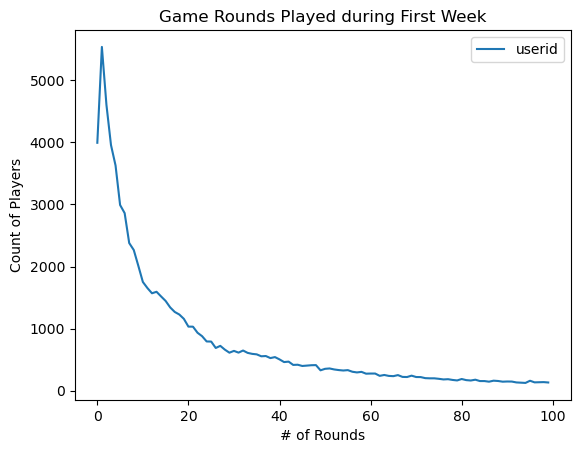

In [44]:
plot_df = df.groupby('sum_gamerounds').count().reset_index()

ax = plot_df.head(n=100).plot('sum_gamerounds', 'userid')
ax.set_xlabel("# of Rounds")
ax.set_ylabel("Count of Players")
ax.set_title("Game Rounds Played during First Week");

На графике выше мы можем видеть, что некоторые игроки устанавливают игру, но никогда не начинают играть (0 игровых раундов), некоторые игроки играют всего несколько раундов в свою первую неделю, а некоторые становятся настолько увлеченными!

Мы хотим, чтобы игроки полюбили игру и увлеклись ею. Одним из общих показателей в игровой индустрии является удержание на 1 день: процент игроков, которые возвращаются и играют в игру на следующий день после ее установки. Чем выше удержание на 1 день, тем легче удерживать игроков и создавать большую базу игроков.

В качестве первого шага давайте посмотрим, каково общее значение удержания на 1 день.

In [45]:
df_retention = df[["retention_1", "retention_7"]].mean()*100
print(f"коэффициент удержания за 1 день: {round(df_retention[0],2)}% \
      \nкоэффициент удержания за 7 дней: {round(df_retention[1],2)}%")

коэффициент удержания за 1 день: 44.52%       
коэффициент удержания за 7 дней: 18.61%


44,5% игроков возвращаются в игру через 1 день после установки, а 18 % игроков возвращаются в игру через 7 дней после установки.. Теперь, когда у нас есть показатель, давайте посмотрим, как удержание на 1 день различается между двумя группами AB.

In [46]:
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

Удержание на 1 день немного уменьшилось, когда ворота были перемещены на уровень 40 (44,2%) по сравнению с контрольной группой, когда они находились на уровне 30 (44,8%). Это небольшое изменение, но даже небольшие изменения в удержании могут иметь большое значение. Однако, хотя мы уверены в разнице в данных, насколько мы можем быть уверены в том, что ворота на уровне 40 будут хуже в будущем?

Существует несколько способов оценить достоверность этих показателей удержания. Здесь мы воспользуемся методом блочного бутстрепа: мы многократно перезагружаем наш набор данных (с замещением) и вычисляем удержание на 1 день для этих выборок. Изменчивость удержания на 1 день даст нам представление о том, насколько неопределены эти показатели удержания.

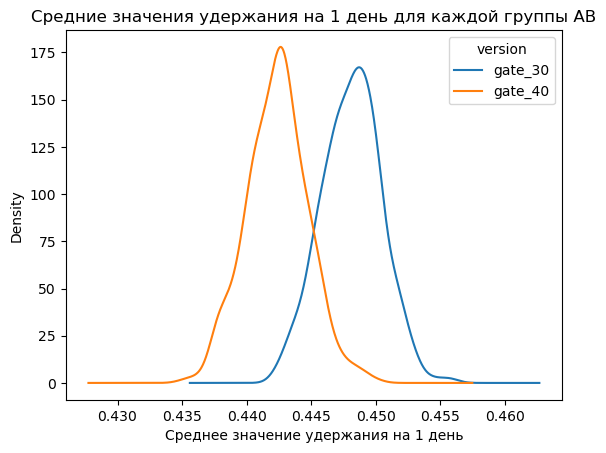

In [47]:
# Создание списка с бутстрэп-средними для каждой группы AB.
boot_1d = []
iterations=500
for i in range(iterations):
    boot_mean = df.sample(frac=1, replace=True).groupby(
        'version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Преобразование списка в DataFrame.
boot_1d = pd.DataFrame(boot_1d)
    
# График оценки плотности ядра для распределений бутстрепа
ax = boot_1d.plot.kde()
ax.set_title('Средние значения удержания на 1 день для каждой группы AB')
ax.set_xlabel('Среднее значение удержания на 1 день');

Данные два распределения выше представляют неопределенность бутстрэпа в отношении того, каким может быть базовое удержание на 1 день для двух групп AB. Просто взглянув на этот график, мы можем заметить, что есть некоторые признаки различия, хотя и незначительные. Давайте рассмотрим более детально разницу в удержании на 1 день.

(Обратите внимание, что в этом блокноте мы ограничили число повторений бутстрэпа до 500, чтобы ускорить вычисления. В "реальной работе" мы, вероятно, увеличили бы это значение до гораздо большего числа, например, 10 000.)


In [48]:
#Проверка первых нескольких строк данных о бутстрэп-удержании на 1 день.
boot_1d.head()

version,gate_30,gate_40
retention_1,0.450542,0.439379
retention_1,0.449203,0.440482
retention_1,0.448434,0.442312
retention_1,0.448646,0.441064
retention_1,0.449492,0.438943


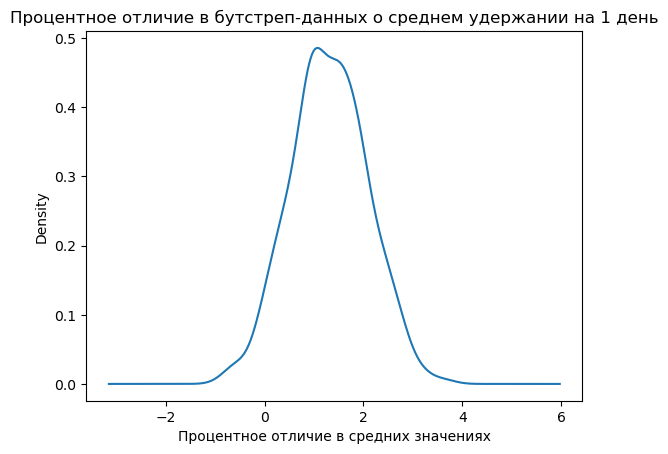

In [49]:
#Добавляем столбц с процентным отличием между двумя группами AB.
boot_1d['diff'] = ((boot_1d.gate_30 - boot_1d.gate_40)
                   / boot_1d.gate_40 * 100)
#Построение графика процентного отличия в бутстреп-выборке.
ax = boot_1d['diff'].plot.kde()
ax.set_xlabel('Процентное отличие в средних значениях')
ax.set_title('Процентное отличие в бутстреп-данных о среднем удержании на 1 день');

Из этой диаграммы мы видим, что наиболее вероятное процентное отличие составляет около 1% - 2%, и что большая часть распределения находится выше 0%, в пользу ворот на уровне 30. Но какова вероятность того, что отличие выше 0%? 

In [50]:
# Расчет вероятности того, что удержание на 1 день выше, когда ворота находятся на уровне 30.
prob = (boot_1d['diff'] > 0).sum() / len(boot_1d['diff'])

# Отображение вероятности в удобочитаемом формате
'{0:.1%}'.format(prob)

'95.6%'

Анализ Bootstrap говорит нам, что с высокой вероятностью удержание на 1 день будет лучше, когда ворота находятся на уровне 30. Однако, поскольку игроки играли в игру всего один день, вероятно, что большинство игроков еще не достигли уровня 30. Иными словами, многие игроки не будут затронуты воротами, даже если они находятся уже на уровне 30.

Однако, после недели игры большее количество игроков должны достичь уровня 40, поэтому имеет смысл также рассмотреть удержание на 7 дней. То есть, какой процент людей, установивших игру, появляется через неделю, чтобы снова играть в игру.

Давайте начнем с расчета удержания на 7 дней для двух групп AB.

In [51]:
#Расчет удержания на 7 дней для обеих групп AB
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Как и с удержанием на 1 день, мы видим, что удержание на 7 дней немного ниже (18,2%), когда ворота находятся на уровне 40, чем когда ворота находятся на уровне 30 (19,0%). Это отличие также больше, чем для удержания на 1 день, предположительно потому что больше игроков успело достигнуть первых ворот. Мы также видим, что общее удержание на 7 дней ниже, чем общее удержание на 1 день; меньше людей играют через неделю после установки, чем в день установки.

Используем анализ бутстрэпа, чтобы определить, насколько уверены мы должны быть в разнице между группами AB.

'100.0%'

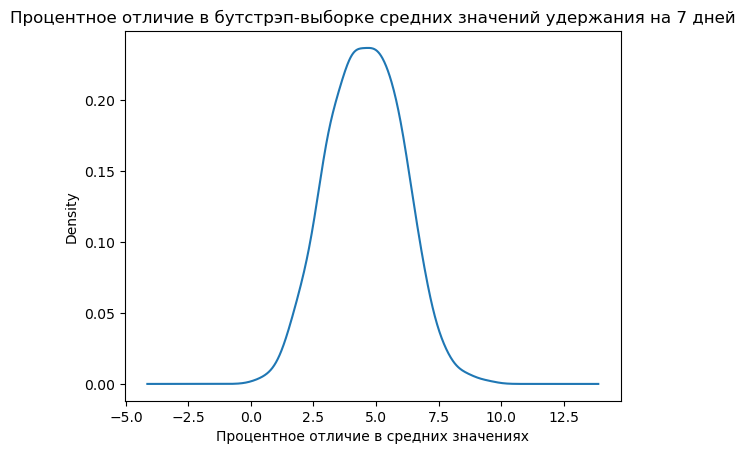

In [52]:
# Создание списка с бутстреп-средними для каждой группы AB
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby(
        'version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Преобразование списка в DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Добавление столбца с процентным отличием между двумя группами AB
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / 
                   boot_7d['gate_40'] * 100)

# Построение графика процентного отличия в бутстреп-выборке
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel("Процентное отличие в средних значениях")
ax.set_title('Процентное отличие в бутстрэп-выборке средних значений удержания на 7 дней');

# Расчет вероятности того, что удержание на 7 дней будет выше, когда ворота находятся на уровне 30
prob = (boot_7d['diff'] > 0).mean()

# Отображение вероятности в удобочитаемом формате
'{0:.1%}'.format(prob)

<h1> Вывод </h1> 

Результаты бутстрэп-анализа свидетельствуют о том, что имеются убедительные аргументы в пользу того, что удержание на 7 дней выше, когда ворота находятся на уровне 30 по сравнению с уровнем 40. Вывод заключается в следующем: если мы хотим сохранить высокое удержание, как на 1-й день, так и на 7-й день, мы не должны перемещать ворота с уровня 30 на уровень 40. Конечно, мы могли бы изучать и другие метрики, такие как количество сыгранных игровых раундов или количество покупок в игре в двух группах AB. Но удержание является одним из наиболее важных показателей. Если мы не удерживаем нашу базу игроков, не имеет значения, сколько денег они тратят внутри игры.

Когда ворота перемещаются на уровень 40, меньше игроков достигают этой точки, и они склонны бросить игру, просто потому что потеряли интерес к ней.


Исходя из данных и анализа бутстрэпа,НЕ следует перемещать ворота с уровня 30 на уровень 40.